## Section 1 — Connect to DB + Load Alerts

Loads alerts generated by the HIGH FAN-IN VELOCITY KPI.
Each alert represents a wallet that received funds from multiple distinct senders within a defined time window, with significant total USD inflow.
This behavior may indicate scam collection wallets, mule accounts, or aggregation hubs.

In [3]:
import sqlite3
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR = Path.cwd().parents[0]
DB_PATH = BASE_DIR / "db" / "crypto_fraud.db"
DB_PATH

conn = sqlite3.connect(DB_PATH)

df_alerts = pd.read_sql_query(
    """
    SELECT
      wallet_id,
      chain,
      details,
      created_at
    FROM alerts
    WHERE kpi_name = 'HIGH_FAN_IN_VELOCITY'
    ORDER BY created_at DESC
    """,
    conn,
)

df_alerts.head(10)


,wallet_id,chain,details,created_at
0,1HaT9qSGL6XycatsPp5zaKRfBGJe5vUtfo,bitcoin,"distinct_senders=6, total_inflow_usd=515700.00...",2025-12-27T11:26:14.823538Z
1,0x18604f3aad07fc61b7c8b8fa1bb6d60ac6aee0b8,ethereum,"distinct_senders=11, total_inflow_usd=826.64, ...",2025-12-27T11:26:14.819760Z
2,0x3328f7f4a1d1c57c35df56bbf0c9dcafca309c49,ethereum,"distinct_senders=20, total_inflow_usd=5909.81,...",2025-12-27T11:26:14.819760Z
3,0x3a09c40f8f7b93c8c7e09a5422e56dfe7c7d2794,ethereum,"distinct_senders=4, total_inflow_usd=7631.63, ...",2025-12-27T11:26:14.819760Z
4,0x53c85c8f2abcace0430461b9d33e9950efd32d82,ethereum,"distinct_senders=6, total_inflow_usd=2119.18, ...",2025-12-27T11:26:14.819760Z
5,0x5866ef6df11409134170f4fc84843ce2f1ee226e,ethereum,"distinct_senders=3, total_inflow_usd=619.99, w...",2025-12-27T11:26:14.819760Z
6,0x681f537842609da902ad3e71b140bf93975b1c69,ethereum,"distinct_senders=15, total_inflow_usd=1242.91,...",2025-12-27T11:26:14.819760Z
7,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,ethereum,"distinct_senders=16, total_inflow_usd=3946.61,...",2025-12-27T11:26:14.819760Z
8,0x974caa59e49682cda0ad2bbe82983419a2ecc400,ethereum,"distinct_senders=33, total_inflow_usd=2386.33,...",2025-12-27T11:26:14.819760Z
9,0xa9d1e08c7793af67e9d92fe308d5697fb81d3e43,ethereum,"distinct_senders=4, total_inflow_usd=16064.52,...",2025-12-27T11:26:14.819760Z


## Section 2 — Parse KPI Attributes

What this section does

The KPI details field is stored as a text string (e.g., distinct_senders, total_inflow_usd).
Here we parse it into structured numeric fields so we can:

analyze the distribution of KPI metrics

compare wallets by inflow behavior

perform statistical / behavioral aggregation

In [4]:
def parse_details(details):
    parts = details.split(", ")
    parsed = {}
    for p in parts:
        k, v = p.split("=")
        parsed[k] = float(v)
    return parsed

parsed = df_alerts["details"].apply(parse_details).tolist()
metrics = pd.DataFrame(parsed)

df = pd.concat([df_alerts, metrics], axis=1)
df.head(5)


,wallet_id,chain,details,created_at,distinct_senders,total_inflow_usd,window_hours
0,1HaT9qSGL6XycatsPp5zaKRfBGJe5vUtfo,bitcoin,"distinct_senders=6, total_inflow_usd=515700.00...",2025-12-27T11:26:14.823538Z,6.0,515700.00,24.0
1,0x18604f3aad07fc61b7c8b8fa1bb6d60ac6aee0b8,ethereum,"distinct_senders=11, total_inflow_usd=826.64, ...",2025-12-27T11:26:14.819760Z,11.0,826.64,24.0
2,0x3328f7f4a1d1c57c35df56bbf0c9dcafca309c49,ethereum,"distinct_senders=20, total_inflow_usd=5909.81,...",2025-12-27T11:26:14.819760Z,20.0,5909.81,24.0
3,0x3a09c40f8f7b93c8c7e09a5422e56dfe7c7d2794,ethereum,"distinct_senders=4, total_inflow_usd=7631.63, ...",2025-12-27T11:26:14.819760Z,4.0,7631.63,24.0
4,0x53c85c8f2abcace0430461b9d33e9950efd32d82,ethereum,"distinct_senders=6, total_inflow_usd=2119.18, ...",2025-12-27T11:26:14.819760Z,6.0,2119.18,24.0


## Section 3 — Top Suspicious Wallets

Groups alerts by wallet and chain to identify:

wallets that repeatedly trigger HIGH FAN-IN

average number of unique senders per alert

average USD inflow during flagged windows

Repeated HIGH FAN-IN activity across multiple windows may suggest coordinated funneling patterns.

In [5]:
df_summary = (
    df.groupby(["wallet_id", "chain"])
      .agg(
          alerts_count=("wallet_id", "count"),
          avg_senders=("distinct_senders", "mean"),
          avg_inflow_usd=("total_inflow_usd", "mean")
      )
      .reset_index()
      .sort_values("alerts_count", ascending=False)
)

df_summary.head(10)


,wallet_id,chain,alerts_count,avg_senders,avg_inflow_usd
0,0x18604f3aad07fc61b7c8b8fa1bb6d60ac6aee0b8,ethereum,1,11.0,826.64
1,0x3328f7f4a1d1c57c35df56bbf0c9dcafca309c49,ethereum,1,20.0,5909.81
2,0x3a09c40f8f7b93c8c7e09a5422e56dfe7c7d2794,ethereum,1,4.0,7631.63
3,0x53c85c8f2abcace0430461b9d33e9950efd32d82,ethereum,1,6.0,2119.18
4,0x5866ef6df11409134170f4fc84843ce2f1ee226e,ethereum,1,3.0,619.99
5,0x681f537842609da902ad3e71b140bf93975b1c69,ethereum,1,15.0,1242.91
6,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,ethereum,1,16.0,3946.61
7,0x974caa59e49682cda0ad2bbe82983419a2ecc400,ethereum,1,33.0,2386.33
8,0xa9d1e08c7793af67e9d92fe308d5697fb81d3e43,ethereum,1,4.0,16064.52
9,0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511,ethereum,1,9.0,82522.44


## Section 4 — Visualizations:

Alert Count Per Wallet:

Wallets with a high alert count are more likely to be:

scam collection wallets

phishing clusters

laundering aggregation points

A single alert event can be random —
multiple alerts represent consistent suspicious behavior

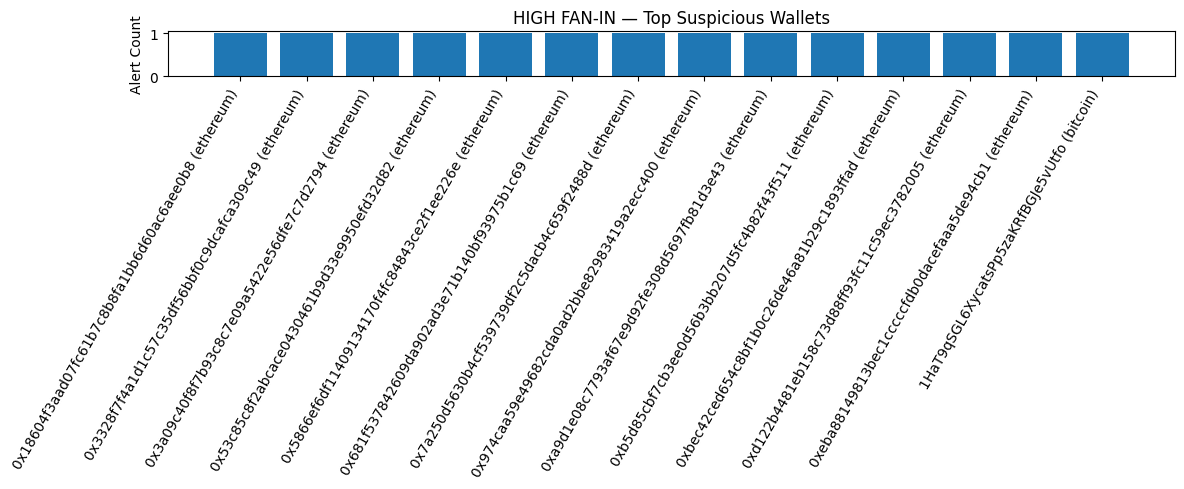

In [6]:
plt.figure(figsize=(12,5))
x = df_summary["wallet_id"] + " (" + df_summary["chain"] + ")"
plt.bar(x, df_summary["alerts_count"])

plt.xticks(rotation=60, ha="right")
plt.ylabel("Alert Count")
plt.title("HIGH FAN-IN — Top Suspicious Wallets")
plt.tight_layout()
plt.show()


Avg USD Inflow:

This chart highlights wallets where the inflow value per burst is relatively high.
High fan-in + high USD value may indicate:

fraud consolidation

investment scam wallets

potential cash-out preparation

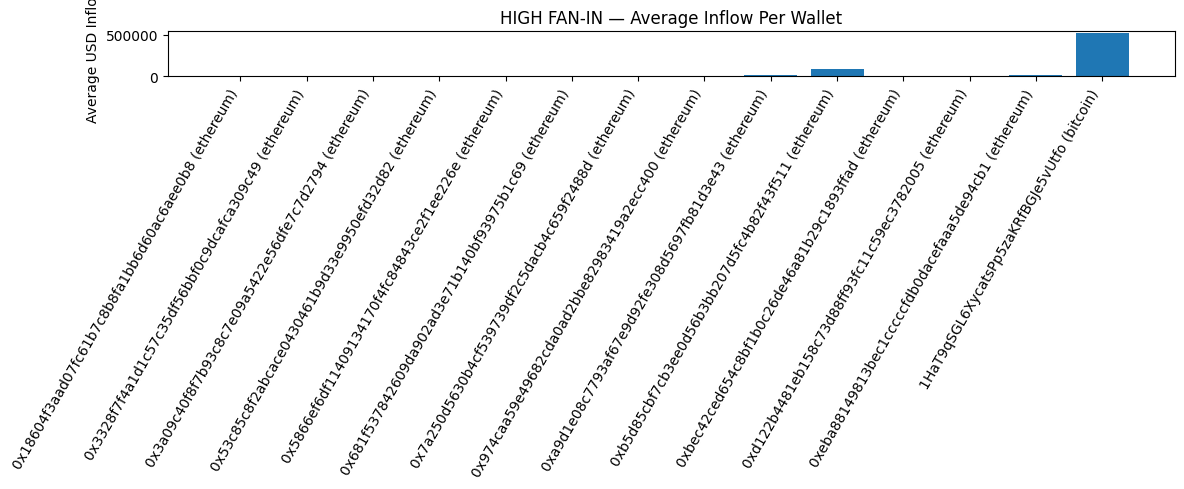

In [7]:
plt.figure(figsize=(12,5))
plt.bar(x, df_summary["avg_inflow_usd"])

plt.xticks(rotation=60, ha="right")
plt.ylabel("Average USD Inflow")
plt.title("HIGH FAN-IN — Average Inflow Per Wallet")
plt.tight_layout()
plt.show()
